<a href="https://colab.research.google.com/github/harshvs4/ViT_1/blob/main/model10_EVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/harshvs4/codewrapper

Cloning into 'codewrapper'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 204 (delta 56), reused 0 (delta 0), pack-reused 107
Receiving objects: 100% (204/204), 71.28 KiB | 10.18 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
!pip install -r /content/codewrapper/codewrapper_requirement.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 80.8 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=cdebcb5c4e7824214fdac3241048ec3cdb4da38ef11c94224f4a31d297d74ac0
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3


In [3]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from torchsummary import summary

from codewrapper.utils.load_data import Cifar10DataLoader
from codewrapper.utils.transforms import CustomResnetTransforms
from codewrapper.model.session10_model import ViT
from codewrapper.utils.gradcam import generate_gradcam, plot_gradcam
from codewrapper.utils.train import Train
from codewrapper.utils.test import Test
from codewrapper.utils.helper import *
from codewrapper.main import *

In [4]:
is_cuda_available, device = get_device()

NUM_CLASSES, IMAGE_SIZE = 10, 32
model = ViT(NUM_CLASSES, IMAGE_SIZE, channels=32, head_channels=8, num_blocks=4, patch_size=2, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.1)
#summary(model, input_size=(3, 32, 32))

In [6]:
model.to(device)

ViT(
  (0): ToEmbedding(
    (0): ToPatches(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (1): AddPositionEmbedding()
    (2): Dropout(p=0.0, inplace=False)
  )
  (1): TransformerStack(
    (0): TransformerBlock(
      (0): Residual(
        (residual): Sequential(
          (0): LayerNormChannels(
            (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SelfAttention2d(
            (to_keys): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (to_queries): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (to_values): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (unifyheads): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Residual(
        (residual): Sequential(
          (0): La

In [7]:
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              GELU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           4,128
AddPositionEmbedding-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
         LayerNorm-6           [-1, 16, 16, 32]              64
 LayerNormChannels-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           1,056
            Conv2d-9           [-1, 32, 16, 16]           1,056
           Conv2d-10           [-1, 32, 16, 16]           1,056
           Conv2d-11           [-1, 32, 16, 16]           1,056
  SelfAttention2d-12           [-1, 32, 16, 16]               0
          Dropout-13           [-1, 32, 16, 16]               0
         Residual-14           [-1, 3

In [8]:
cifar10 = Cifar10DataLoader(CustomResnetTransforms, 512, is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


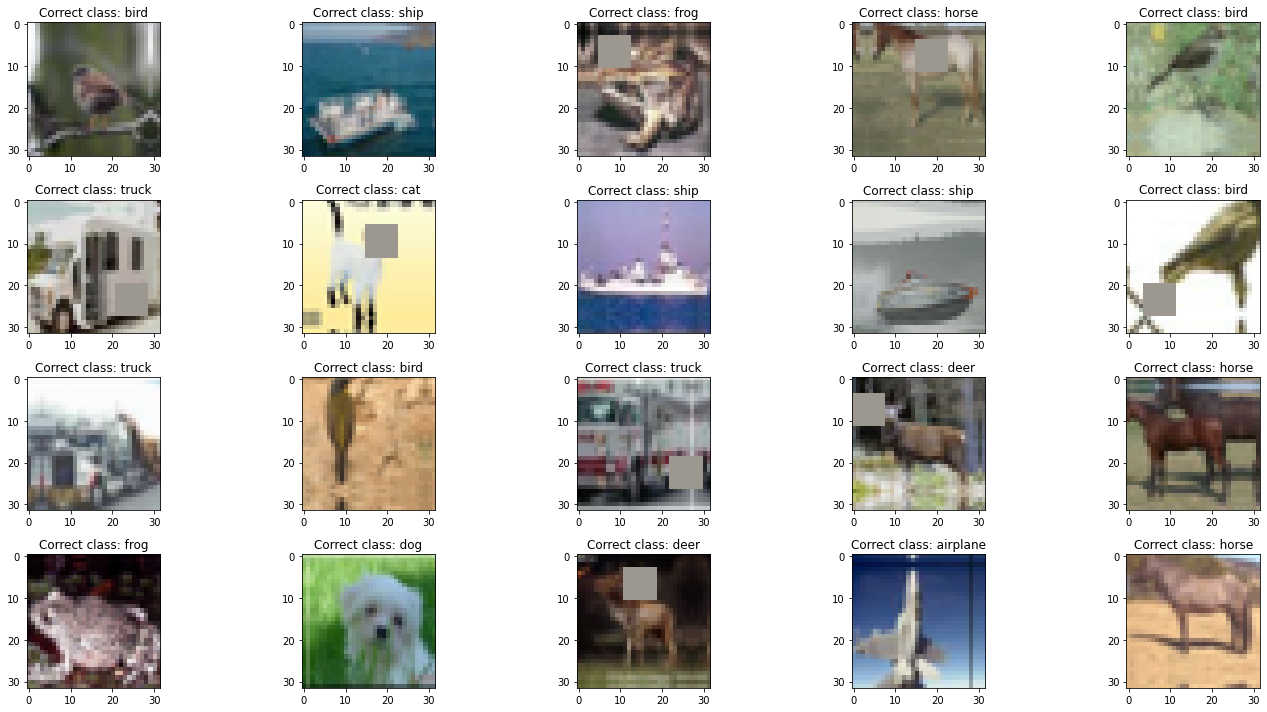

In [9]:
show_training_images(train_loader, 20, cifar10.classes)

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.29E-04


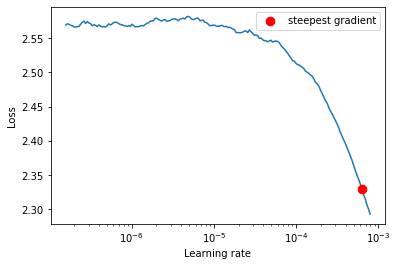

Min Loss = 2.2579916175013675, Max LR = 0.001


In [10]:
#model = ViT()

cifar10_exp = Cifar10DataLoader(DefaultTransforms, 512, is_cuda_available, shuffle=False)
train_loader_exp = cifar10_exp.get_loader(train=True)

optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

min_loss, max_lr = get_lr(model=model, train_loader=train_loader_exp, optimizer=optimizer, criterion=criterion, device=device, end_lr=0.001, num_iter=200,)

In [25]:
EPOCHS = 24

scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=5 / EPOCHS, div_factor=100,three_phase=False, final_div_factor=1000, anneal_strategy="linear",)

train = Train(model, train_loader, optimizer, criterion, device)
test = Test(model, test_loader, criterion, device)

model, history = train_model(train, test, NUM_EPOCHS=EPOCHS, scheduler=scheduler, save_best=False)

EPOCH = 1 | LR = 0.00020840490797546012 | Loss = 1.17 | Batch = 97 | Accuracy = 55.74: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]


Test set: Average loss: 0.0023, Accuracy: 5841/10000 (58.41%)



EPOCH = 2 | LR = 0.0004068098159509203 | Loss = 1.28 | Batch = 97 | Accuracy = 55.88: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0023, Accuracy: 5850/10000 (58.50%)



EPOCH = 3 | LR = 0.0006052147239263804 | Loss = 1.21 | Batch = 97 | Accuracy = 56.46: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0023, Accuracy: 5930/10000 (59.30%)



EPOCH = 4 | LR = 0.0008036196319018405 | Loss = 1.11 | Batch = 97 | Accuracy = 56.82: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0023, Accuracy: 5924/10000 (59.24%)



EPOCH = 5 | LR = 0.000999462948442535 | Loss = 1.16 | Batch = 97 | Accuracy = 57.34: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0022, Accuracy: 6014/10000 (60.14%)



EPOCH = 6 | LR = 0.000946831895810956 | Loss = 1.11 | Batch = 97 | Accuracy = 57.90: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0022, Accuracy: 6112/10000 (61.12%)



EPOCH = 7 | LR = 0.0008942008431793771 | Loss = 1.06 | Batch = 97 | Accuracy = 59.47: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0021, Accuracy: 6178/10000 (61.78%)



EPOCH = 8 | LR = 0.0008415697905477981 | Loss = 1.10 | Batch = 97 | Accuracy = 59.85: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0021, Accuracy: 6300/10000 (63.00%)



EPOCH = 9 | LR = 0.0007889387379162191 | Loss = 1.04 | Batch = 97 | Accuracy = 60.93: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test set: Average loss: 0.0020, Accuracy: 6353/10000 (63.53%)



EPOCH = 10 | LR = 0.0007363076852846401 | Loss = 1.10 | Batch = 97 | Accuracy = 61.85: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0020, Accuracy: 6362/10000 (63.62%)



EPOCH = 11 | LR = 0.0006836766326530613 | Loss = 1.05 | Batch = 97 | Accuracy = 61.94: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0020, Accuracy: 6380/10000 (63.80%)



EPOCH = 12 | LR = 0.0006310455800214822 | Loss = 1.06 | Batch = 97 | Accuracy = 62.73: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0020, Accuracy: 6479/10000 (64.79%)



EPOCH = 13 | LR = 0.0005784145273899033 | Loss = 1.03 | Batch = 97 | Accuracy = 63.05: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0019, Accuracy: 6498/10000 (64.98%)



EPOCH = 14 | LR = 0.0005257834747583244 | Loss = 1.10 | Batch = 97 | Accuracy = 63.58: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0019, Accuracy: 6575/10000 (65.75%)



EPOCH = 15 | LR = 0.00047315242212674536 | Loss = 0.96 | Batch = 97 | Accuracy = 63.88: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0019, Accuracy: 6603/10000 (66.03%)



EPOCH = 16 | LR = 0.00042052136949516654 | Loss = 1.02 | Batch = 97 | Accuracy = 64.27: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0019, Accuracy: 6653/10000 (66.53%)



EPOCH = 17 | LR = 0.0003678903168635875 | Loss = 0.95 | Batch = 97 | Accuracy = 64.73: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0019, Accuracy: 6672/10000 (66.72%)



EPOCH = 18 | LR = 0.0003152592642320085 | Loss = 0.98 | Batch = 97 | Accuracy = 64.85: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0018, Accuracy: 6709/10000 (67.09%)



EPOCH = 19 | LR = 0.00026262821160042966 | Loss = 0.95 | Batch = 97 | Accuracy = 65.26: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0019, Accuracy: 6688/10000 (66.88%)



EPOCH = 20 | LR = 0.00020999715896885063 | Loss = 0.91 | Batch = 97 | Accuracy = 65.37: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0018, Accuracy: 6750/10000 (67.50%)



EPOCH = 21 | LR = 0.0001573661063372717 | Loss = 1.01 | Batch = 97 | Accuracy = 65.64: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0018, Accuracy: 6734/10000 (67.34%)



EPOCH = 22 | LR = 0.00010473505370569268 | Loss = 1.01 | Batch = 97 | Accuracy = 65.93: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0018, Accuracy: 6786/10000 (67.86%)



EPOCH = 23 | LR = 5.210400107411386e-05 | Loss = 0.99 | Batch = 97 | Accuracy = 65.91: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0018, Accuracy: 6776/10000 (67.76%)



EPOCH = 24 | LR = -5.270515574650608e-07 | Loss = 0.99 | Batch = 97 | Accuracy = 66.30: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0018, Accuracy: 6804/10000 (68.04%)



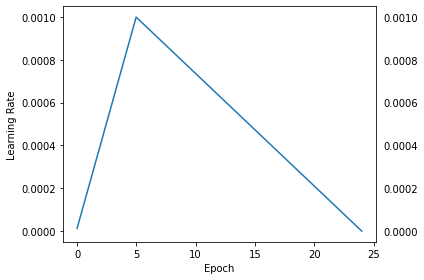

In [26]:
show_lr_history(train, EPOCHS)

In [27]:
print(f"Max LR = {max(train.lr_history)}")
print(f"Min LR = {min(train.lr_history)}")

Max LR = 0.001
Min LR = -5.270515574650608e-07


In [28]:
misclassified_images, predictions, labels = test.get_misclassified_images()

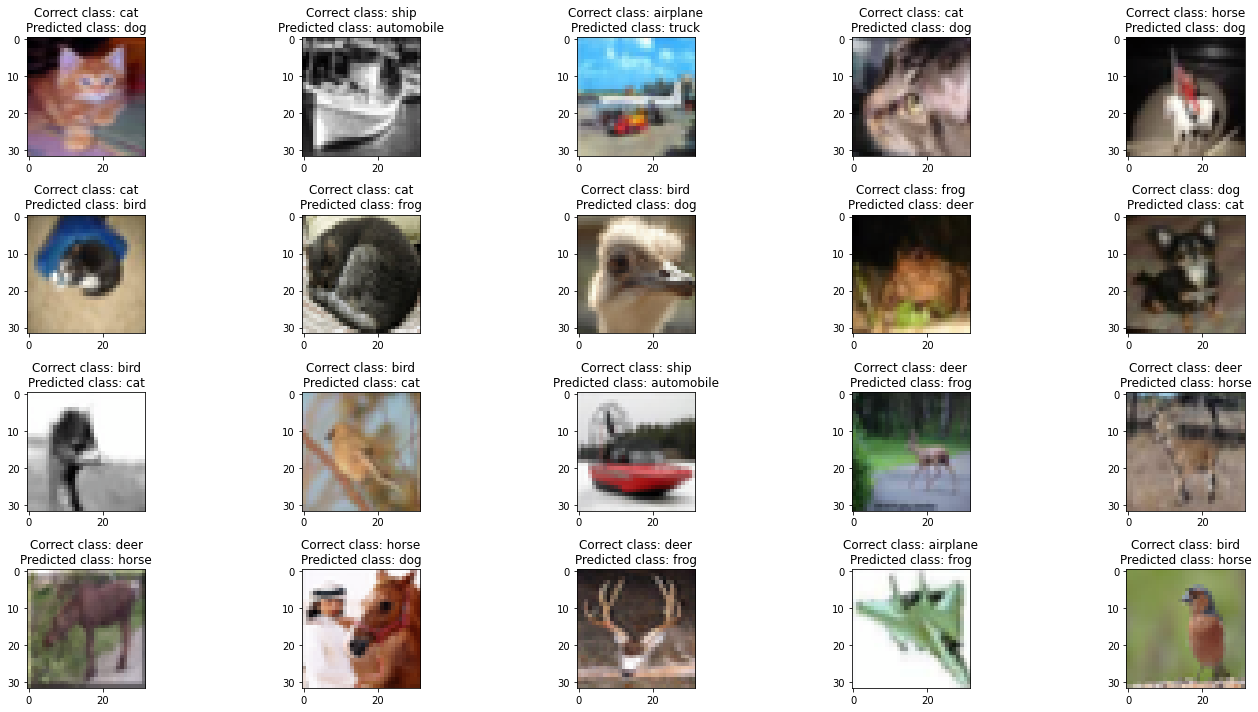

In [29]:
show_misclassified_images(misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes)

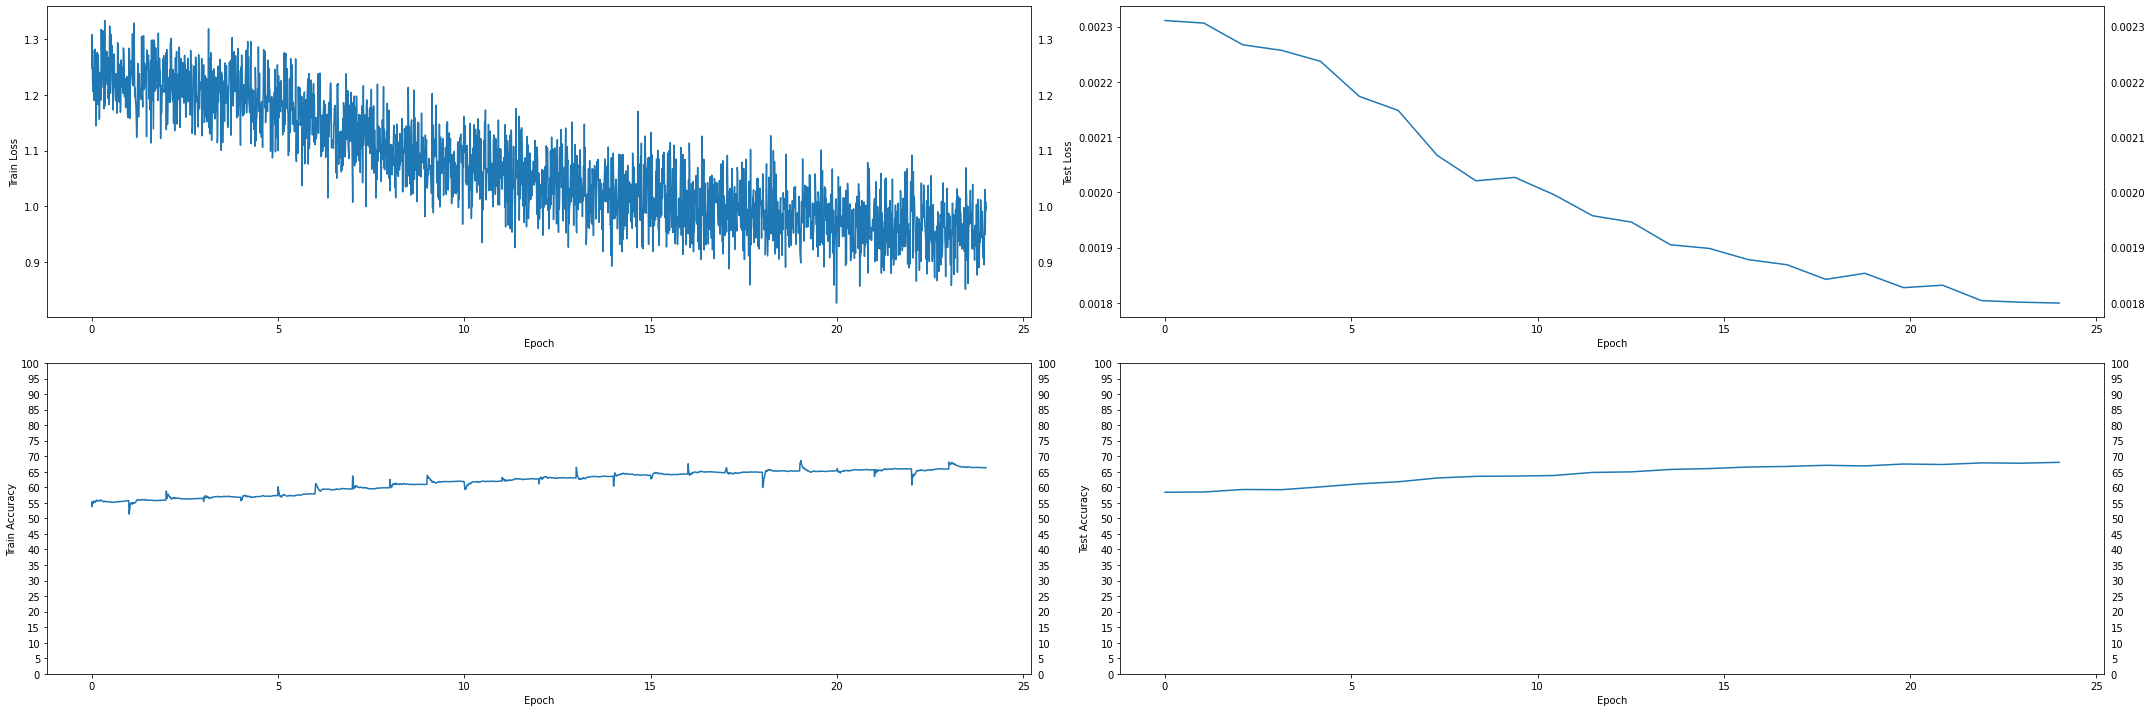

In [30]:
show_losses_and_accuracies(train, test, EPOCHS)

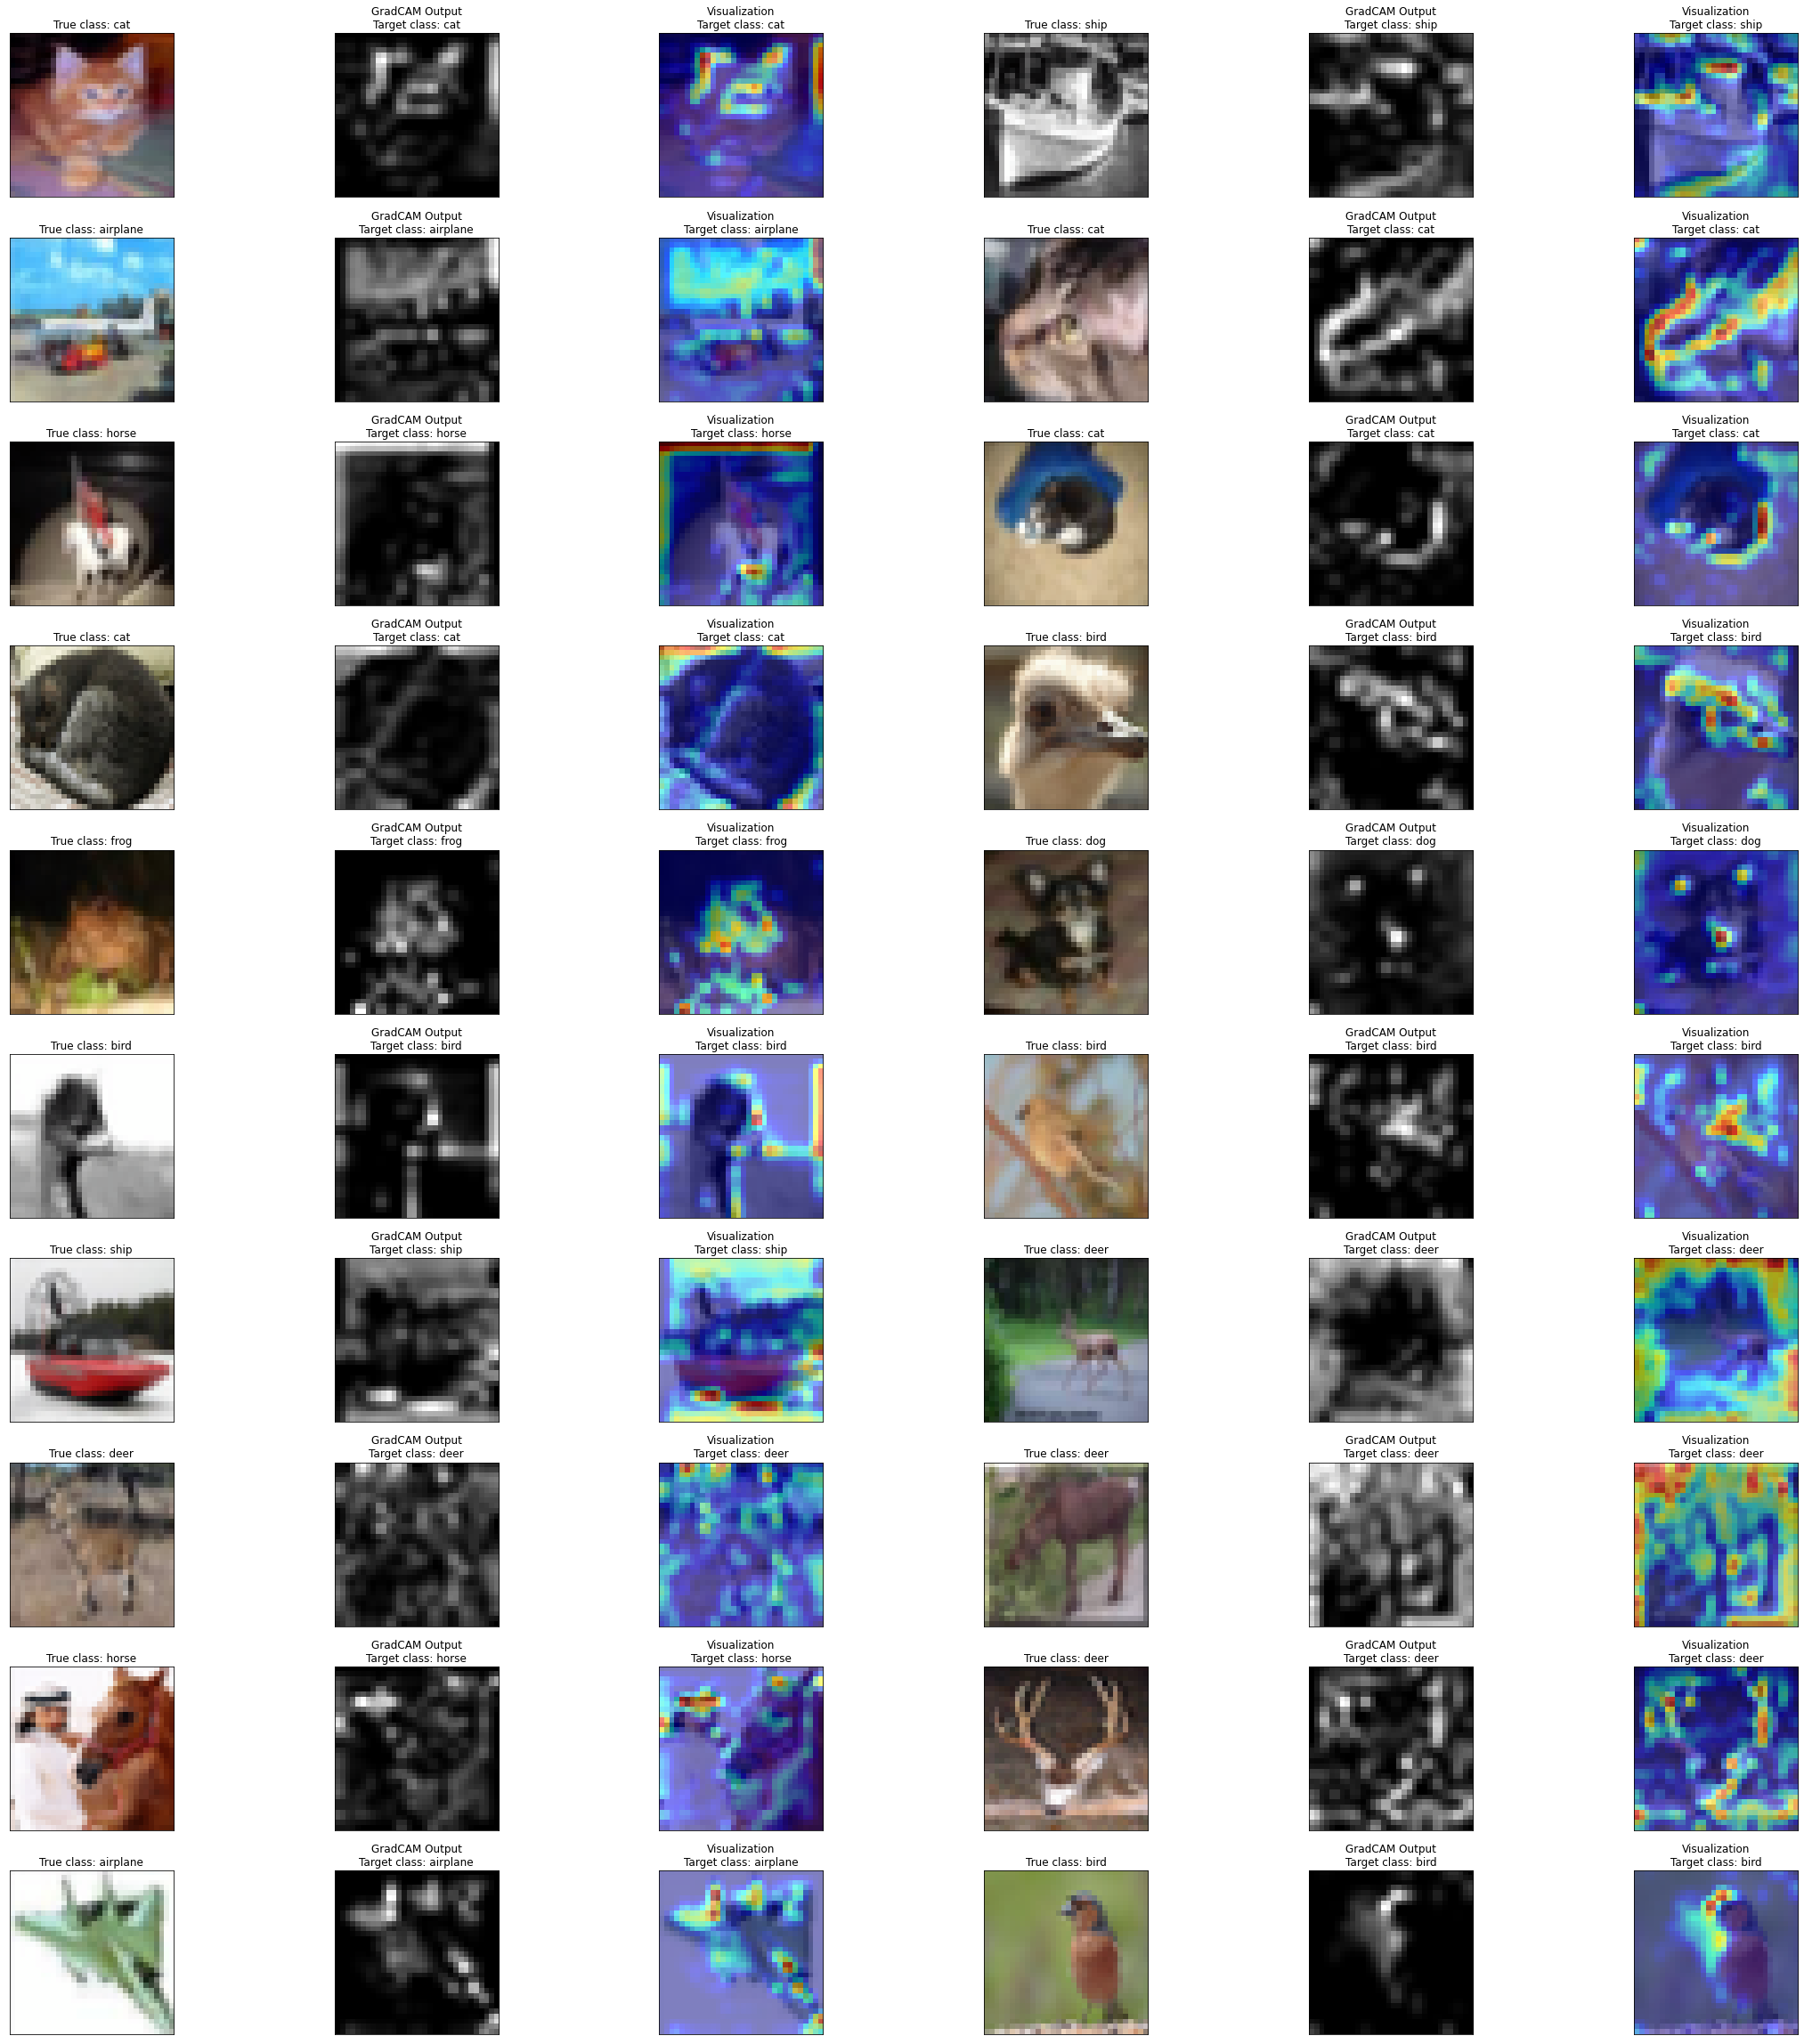

In [31]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], labels[:20], "1.0", cifar10.classes)